In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "../dataset/CAC40_stocks_2010_2021.csv"
data = pd.read_csv(file_path)
validation_days = 20   # Nombre de jours de validation

# Data preprocessing
specific_stock = 'FTI'  # Remplacez par le nom du stock souhaité
if 'Stock' in data.columns:  # Vérifiez que la colonne existe
    data_for_stock = data[data['Stock'] == specific_stock]
data_minus_validation = data_for_stock[:-validation_days]
data_minus_validation

,CompanyName,Stock,High,Low,Open,Close,Volume,Date
0,TechnipFMC,FTI,29.855000,29.075001,29.075001,29.615000,1908400.0,2010-01-04
1,TechnipFMC,FTI,30.270000,29.555000,29.610001,30.125000,2206600.0,2010-01-05
2,TechnipFMC,FTI,30.305000,29.434999,30.040001,30.264999,2724200.0,2010-01-06
3,TechnipFMC,FTI,30.219999,29.715000,30.155001,29.915001,2581000.0,2010-01-07
4,TechnipFMC,FTI,30.500000,29.625000,29.830000,30.450001,3280400.0,2010-01-08
...,...,...,...,...,...,...,...,...
2764,TechnipFMC,FTI,9.610000,9.240000,9.590000,9.400000,1249300.0,2020-12-24
2765,TechnipFMC,FTI,9.740000,9.380000,9.600000,9.410000,2982700.0,2020-12-28
2766,TechnipFMC,FTI,9.620000,9.380000,9.580000,9.510000,3060900.0,2020-12-29
2767,TechnipFMC,FTI,9.840000,9.490000,9.510000,9.620000,2889500.0,2020-12-30


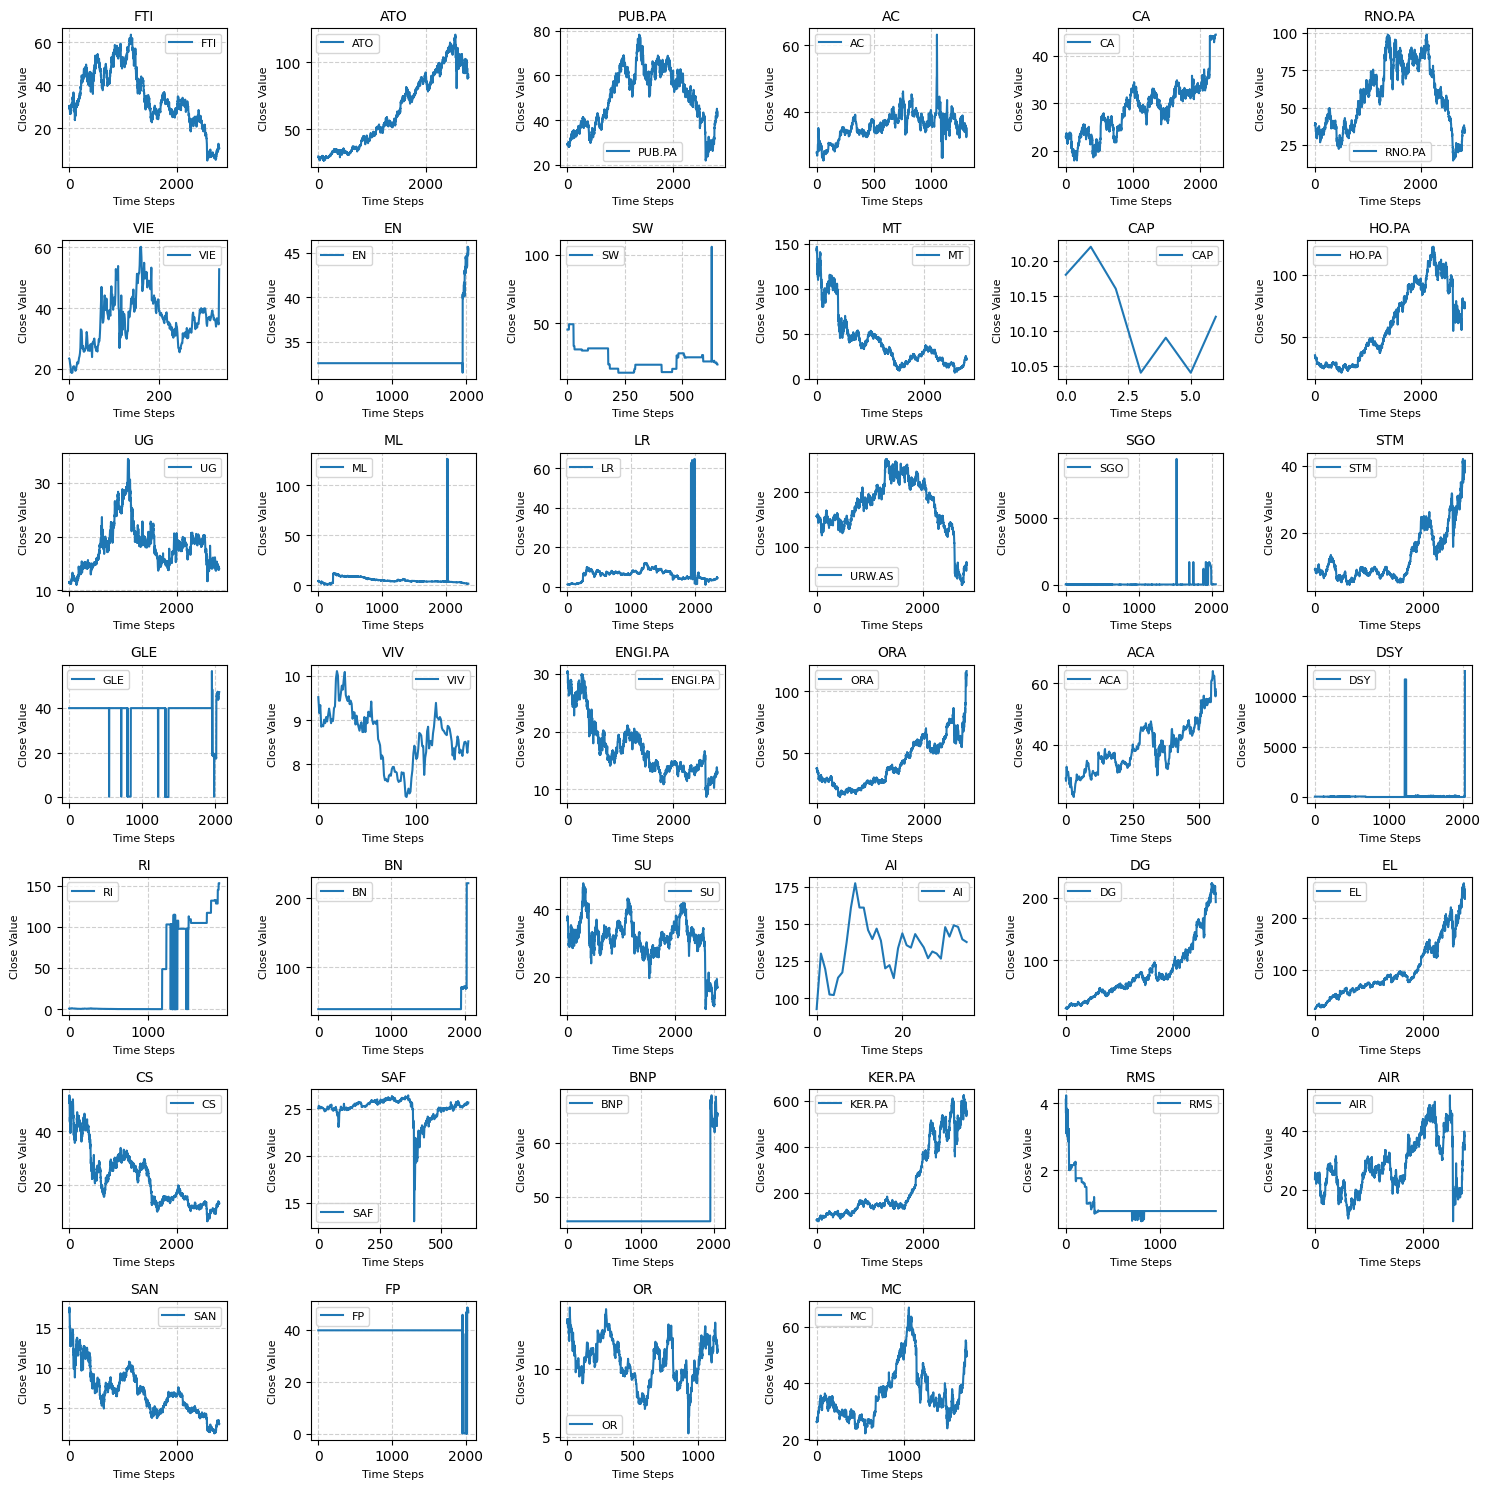

In [3]:
plt.figure(figsize=(15, 15))
unique_stocks = data['Stock'].unique()
num_stocks = len(unique_stocks)

# Calculate grid size
rows = int(np.ceil(np.sqrt(num_stocks)))
cols = int(np.ceil(num_stocks / rows))

for i, stock_name in enumerate(unique_stocks, 1):
    stock_data = data[data['Stock'] == stock_name]
    plt.subplot(rows, cols, i)
    plt.plot(stock_data['Close'].values, label=stock_name)
    plt.title(stock_name, fontsize=10)
    plt.xlabel("Time Steps", fontsize=8)
    plt.ylabel("Close Value", fontsize=8)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

In [19]:
scaled_data = scaler.fit_transform(data_minus_validation['Close'].values.reshape(-1, 1))
scaled_data

array([[0.4205264 ],
       [0.42924286],
       [0.4316356 ],
       ...,
       [0.07690993],
       [0.07878994],
       [0.0750299 ]])

In [6]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [7]:
time_step = 100
X, y = create_dataset(scaled_data, time_step)

In [8]:
train_size = 0.8

In [9]:
train_size = int(len(X) * 0.6)  # 80% for training
val_size = int(len(X) * 0.2)    # 15% for validation

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (1600, 100) (1600,)
Validation data shape: (533, 100) (533,)
Test data shape: (535, 100) (535,)


Finding best hyperparameters

In [10]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    activation_function = hp.Choice('activation_function', values=['relu', 'tanh'])

    model.add(LSTM(units=lstm_units, activation=activation_function, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=lstm_units, activation=activation_function))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Use Keras Tuner to find the best hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='stock_prediction'
)

# Perform the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

2025-03-27 11:23:18.670780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 11:23:18.800456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743070998.849887    6946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743070998.865765    6946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743070998.979608    6946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Reloading Tuner from my_dir/stock_prediction/tuner0.json
Best Hyperparameters: {'lstm_units': 192, 'dense_units': 64, 'activation_function': 'tanh', 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


W0000 00:00:1743071000.617592    6946 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/abel/personnal_projects/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 192)       │       148,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 192)            │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,089 (1.74 MB)

 Trainable params: 457,089 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveille la perte sur l'ensemble de validation
    patience=10,         # Arrête après 10 epochs sans amélioration
    restore_best_weights=True  # Restaure les poids du meilleur modèle
)

history = best_model.fit(
    X_train, y_train,
    epochs=100,  # Nombre maximum d'epochs
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0668 - mae: 0.1651 - val_loss: 4.6957e-04 - val_mae: 0.0173
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 5.0100e-04 - val_mae: 0.0179
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 4.0344e-04 - val_mae: 0.0160
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 8.8405e-04 - mae: 0.0228 - val_loss: 3.8951e-04 - val_mae: 0.0157
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 7.9947e-04 - mae: 0.0218 - val_loss: 3.7025e-04 - val_mae: 0.0153
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 8.4464e-04 - mae: 0.0226 - val_loss: 3.8166e-04 - val_mae: 0.0155
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 8.9540e-04 - mae: 0.0234 - val_loss: 3.8308e-04 - val_mae: 0.0157
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 8.7007e-04 - mae: 0.0227 - val_loss: 5.0944e-04 - val_

In [12]:
test_loss = best_model.evaluate(X_test, y_test)
test_loss

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.7289e-04 - mae: 0.0096


[0.0002903629210777581, 0.013349798507988453]

In [13]:
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [14]:
original_data = data_minus_validation['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions.reshape(-1)

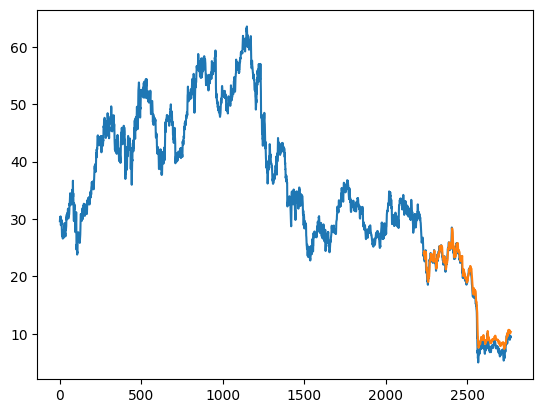

In [15]:
plt.plot(original_data)
plt.plot(predicted_data)

In [16]:
new_predictions = best_model.predict(X_test[-validation_days:])
new_predictions = scaler.inverse_transform(new_predictions)
predicted_data = np.append(predicted_data, new_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


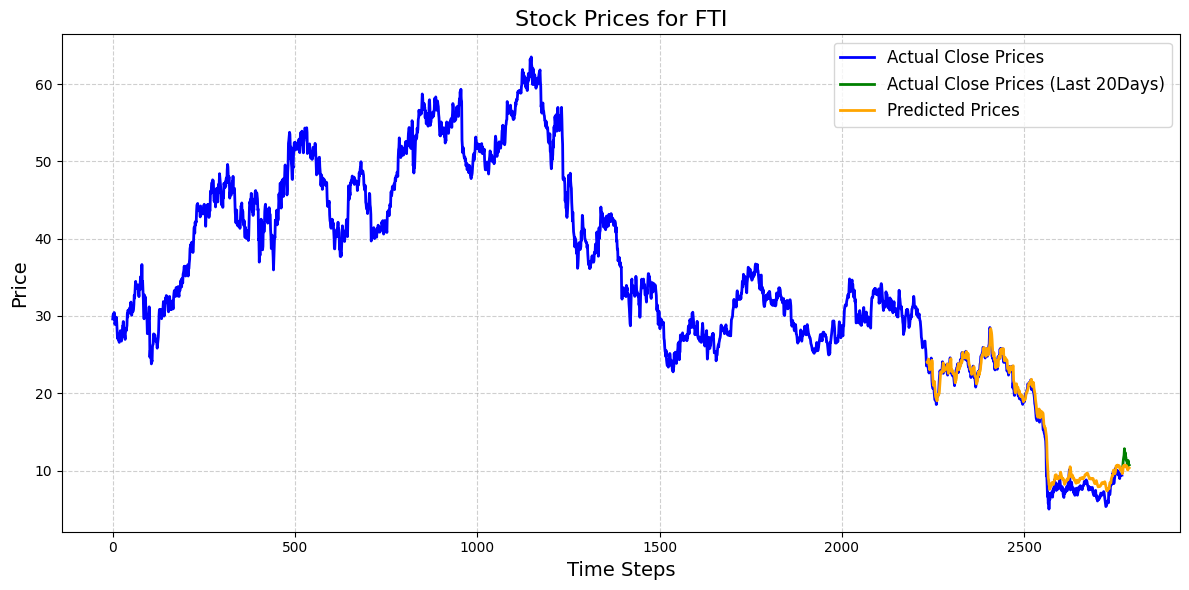

In [17]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the entire Actual Close Prices in blue
plt.plot(data_minus_validation['Close'].values, label='Actual Close Prices', color='blue', linewidth=2)

# Highlight the last validation_days of Actual Close Prices in green
plt.plot(range(len(data_for_stock['Close']) - validation_days, len(data_for_stock['Close'])), data_for_stock['Close'].values[-validation_days:], color='green', linewidth=2, label=f'Actual Close Prices (Last {validation_days}Days)')

# Plot the Predicted Prices in orange
plt.plot(predicted_data, label='Predicted Prices', color='orange', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.title(f"Stock Prices for {specific_stock}", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

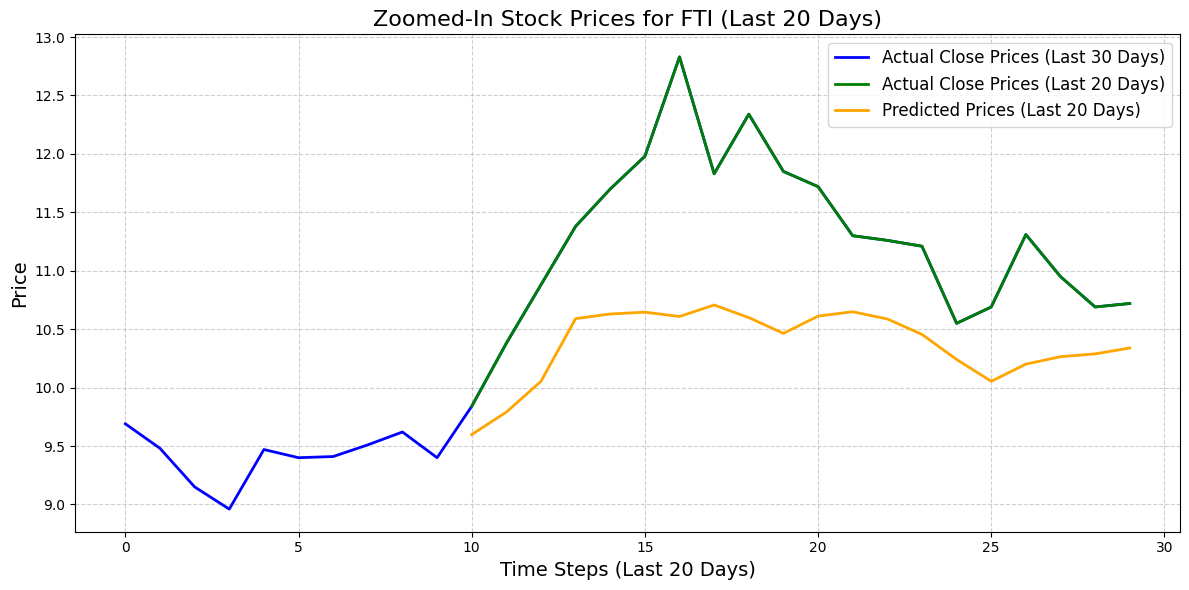

In [18]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the last (validation_days + 10) days of Actual Close Prices in blue
plt.plot(data_for_stock['Close'].values[-(validation_days + 10):], label=f'Actual Close Prices (Last {validation_days + 10} Days)', color='blue', linewidth=2)

# Plot the last validation_days of Actual Close Prices in green, starting after 10 days
plt.plot(range(10, 10 + validation_days), data_for_stock['Close'].values[-validation_days:], label=f'Actual Close Prices (Last {validation_days} Days)', color='green', linewidth=2)

# Plot the last validation_days of Predicted Prices in orange, starting after 10 days
plt.plot(range(10, 10 + validation_days), predicted_data[-validation_days:], label=f'Predicted Prices (Last {validation_days} Days)', color='orange', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.title(f"Zoomed-In Stock Prices for {specific_stock} (Last {validation_days} Days)", fontsize=16)
plt.xlabel(f"Time Steps (Last {validation_days} Days)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()